In [95]:
import os
import numpy as np
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt


# Fonction pour charger les images du dataset
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        # Conversion des images en nuances de gris et redimensionnement
        img = Image.open(img_path).convert('L')
        img = img.resize((32, 32))
        # Mettre les images dans un tableau numpy
        img_array = np.array(img).flatten() / 255.0
        images.append(img_array)
        labels.append(label)
    return images, labels

In [96]:
def load_dataset(base_path):
    train_images, train_labels = [], []
    val_images, val_labels = [], []

    # Boucle qui appelle la fonction load_images_from_folder pour chaque dataset
    dataset_sizes = {}
    for dataset in ['train', 'val', 'test']:
        total_images = 0
        for label in ['PNEUMONIA', 'NORMAL']:
            folder = os.path.join(base_path, dataset, label)
            images, labels = load_images_from_folder(folder, label)
            total_images += len(images)
            if dataset == 'train':
                train_images.extend(images)
                train_labels.extend(labels)
            elif dataset == 'val':
                val_images.extend(images)
                val_labels.extend(labels)

    # Retourne à chaque fois un tableau avec les images d'un côté et les labels de l'autre, et les tailles des datasets
    return (np.array(train_images), np.array(train_labels),
            np.array(val_images), np.array(val_labels))

In [97]:
# Chargement du dataset
base_path = './dataset/'
# train_images, train_labels, val_images, val_labels, test_images, test_labels, dataset_sizes = load_dataset(base_path)

train_images, train_labels, val_images, val_labels = load_dataset(base_path)
train_images, X_test, train_labels, y_test = train_test_split(train_images, train_labels, test_size=0.20, random_state=42)


# Impression des tailles des datasets
# for dataset, size in dataset_sizes.items():
    # print(f'{dataset.capitalize()} set: {size} images')
print(f'Train set: {len(train_images)} images')
print(f'Test set: {len(X_test)} images')
print(f'Validation set: {len(val_images)} images')

Train set: 4672 images
Test set: 1168 images
Validation set: 16 images


In [98]:
# Standardisation des données
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images)
val_images_scaled = scaler.transform(val_images)
test_images_scaled = scaler.transform(test_images)

# Équilibrage des classes avec SMOTE
smote = SMOTE(random_state=42)
test_images_balanced, test_labels_balanced = smote.fit_resample(test_images_scaled, test_labels)

In [99]:
# Algorithme Logistic Regression
# model = LogisticRegression(max_iter=1000, class_weight='balanced', C=0.001)
model = LogisticRegression(max_iter=100, class_weight='balanced', C=10, solver='saga')

In [100]:
# Validation croisée pour une évaluation plus robuste
cv_scores = cross_val_score(model, test_images_balanced, test_labels_balanced, cv=5)
print(f'Cross-Validation Accuracy: {np.mean(cv_scores) * 100:.2f}%')

/Users/lucasperso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lucasperso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lucasperso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lucasperso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-Validation Accuracy: 92.56%


/Users/lucasperso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [101]:
# Entraînement du modèle
model.fit(test_images_balanced, test_labels_balanced)

/Users/lucasperso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=10, class_weight='balanced', solver='saga')

In [102]:
# Prédictions sur les données d'entraînement
test_pred = model.predict(test_images_balanced)
test_accuracy = accuracy_score(test_labels_balanced, test_pred)
print(f'Val Accuracy: {test_accuracy * 100:.2f}%')

Val Accuracy: 98.46%


In [103]:
import pickle

pickle.dump(model, open('logistic_regression.pkl','wb'))

Confusion Matrix:
[[388   2]
 [ 10 380]]


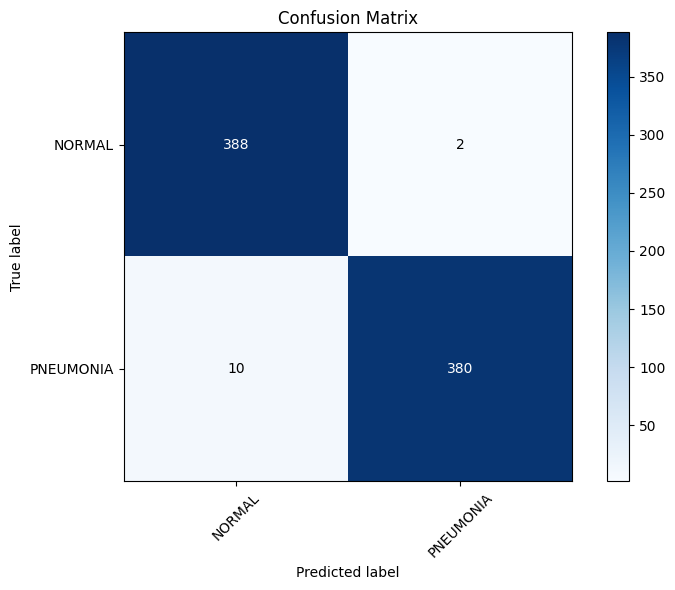

In [104]:
# Matrice de confusion
conf_matrix = confusion_matrix(test_labels_balanced, test_pred)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['NORMAL', 'PNEUMONIA'], rotation=45)
plt.yticks(tick_marks, ['NORMAL', 'PNEUMONIA'])

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             ha="center", va="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [105]:
# Rapport de classification
print('Classification Report:')
print(classification_report(test_labels_balanced, test_pred, target_names=['NORMAL', 'PNEUMONIA']))


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.99      0.98       390
   PNEUMONIA       0.99      0.97      0.98       390

    accuracy                           0.98       780
   macro avg       0.98      0.98      0.98       780
weighted avg       0.98      0.98      0.98       780



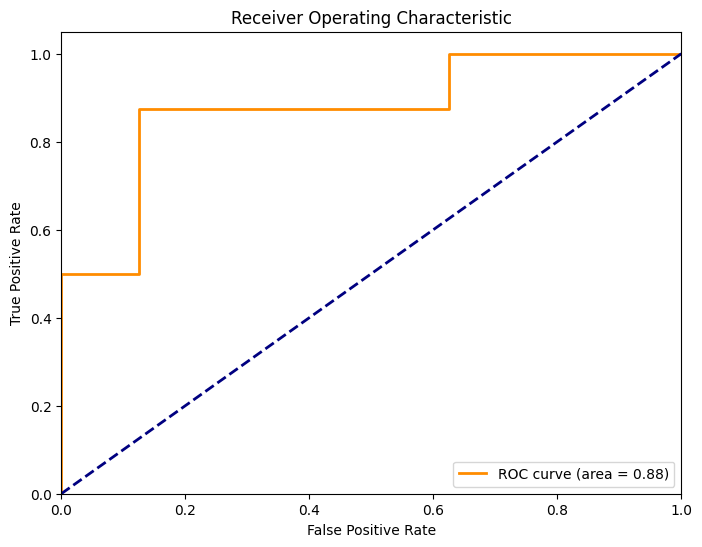

In [106]:
# Courbe ROC
val_prob = model.predict_proba(val_images_scaled)
fpr, tpr, _ = roc_curve(val_labels, val_prob[:, 1], pos_label='PNEUMONIA')
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [107]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'lbfgs']
}

# Initialize the GridSearchCV with the Logistic Regression model
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced'), param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(train_images, train_labels)

# Output the best parameters found
print(f'Best Parameters: {grid_search.best_params_}')
grid_search.fit(train_images, train_labels)
print(f'Best Parameters: {grid_search.best_params_}')
model = grid_search.best_estimator_

/Users/lucasperso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lucasperso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lucasperso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lucasperso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lucasperso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

Best Parameters: {'C': 1, 'solver': 'saga'}


/Users/lucasperso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lucasperso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lucasperso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lucasperso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lucasperso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

Best Parameters: {'C': 1, 'solver': 'saga'}
